## PINN for predicting a SIR model
This is the base case of modeling a SIR model using a Feed Forward Neural Network.

In [8]:
# import libraries
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import math

### Define time, initial conditions and parameters

In [9]:
# define amount of days being predicted and create time tensor
t_days = 500
t_tensor = torch.linspace(0, t_days, t_days+1, requires_grad = True).view(-1, 1)
t_0 = torch.tensor([0], dtype=torch.float32).view(-1,1)

#define initial conditions for SIR model
S_0 = 9999
I_0 = 1
R_0 = 0
N = S_0 + I_0 + R_0

#define model parameters
alpha = 0.05
beta = 0.005

In [10]:
def SIR_numerical(t_array):
    # Initialize arrays of data
    # S: Susceptibles, I: Infected/Infectious, R: Recovered/Removed
    I_array = np.zeros(t_days + 1)
    S_array = np.zeros(t_days + 1)
    R_array = np.zeros(t_days + 1)
    N_array = np.zeros(t_days + 1)

    # Initialize values. Population is sucseptible, small amount infected and 0 recovered
    # I: Infected is typically first
    I_init = 1
    S_init = N - I_init
    R_init = 0

    I_array[0] = I_init
    S_array[0] = S_init
    R_array[0] = R_init
    N_array[0] = N

    # Number of days between data points
    dt = 1

    for i in range(1, t_days + 1):
        I = I_array[i-1]
        S = S_array[i-1]
        R = R_array[i-1]

        dSdt = -alpha*(S*I)/N
        dIdt = alpha*(S*I)/N - beta*I
        dRdt = beta*I

        S_array[i] = S + dt*dSdt
        I_array[i] = I + dt*dIdt
        R_array[i] = R + dt*dRdt
        N_array[i] = S + I + R

    return S_array, I_array, R_array

In [11]:
# compute numerical solution for loss_obs
t_array = np.arange(0, t_days + 1, 1)
S_array, I_array, R_array = SIR_numerical(t_array)
S_obs = torch.tensor(S_array, dtype=torch.float32, requires_grad=True).view(-1,1)
I_obs = torch.tensor(I_array, dtype=torch.float32, requires_grad=True).view(-1,1)
R_obs = torch.tensor(R_array, dtype=torch.float32, requires_grad=True).view(-1,1)
SIR_obs = torch.cat((S_obs, I_obs, R_obs), 1)

In [12]:
def loss_ode(net, t):
    SIR = net(t)

    # Calculate derivates
    dSdt = torch.autograd.grad(SIR[:,0], t, grad_outputs=SIR[:,0], create_graph=True)[0]
    dIdt = torch.autograd.grad(SIR[:,1], t, grad_outputs=SIR[:,1], create_graph=True)[0]
    dRdt = torch.autograd.grad(SIR[:,2], t, grad_outputs=SIR[:,2], create_graph=True)[0]

    # Calculate the residuals using vectorized operations
    S, I, R = SIR[:, 0], SIR[:, 1], SIR[:, 2]

    S, I, R = SIR[:, 0], SIR[:, 1], SIR[:, 2]
    S_r = dSdt - (- beta * S * I)
    I_r = dIdt - (beta * S * I - alpha * I)
    R_r = dRdt - (alpha * I)

    # Combine the residuals into a single tensor and calculate the mean squared error
    residuals = torch.cat((S_r, I_r, R_r))
    loss_ode_squared = torch.mean(residuals**2)
    loss_ode = torch.sqrt(loss_ode_squared)

    ##different approach for calculation
    #S_E = torch.tensor((- beta * S * I)).view(-1, 1)
    #I_E = torch.tensor((beta * S * I - alpha * I)).view(-1, 1)
    #R_E = torch.tensor((alpha * I)).view(-1, 1)
    #S_r = torch.nn.functional.mse_loss(dSdt,S_E)
    #I_r = torch.nn.functional.mse_loss(dIdt,I_E)
    #R_r = torch.nn.functional.mse_loss(dRdt,R_E)
    #loss_ode = (S_r + I_r + R_r)/3

    return loss_ode


#loss function for initial conditoons of S, I and R
def loss_ic(net):
    SIR_t0 = net(t_0)
    loss_ic_squared = (SIR_t0[:, 0]-S_0)**2 + (SIR_t0[:, 1]-I_0)**2 + (SIR_t0[:, 2]-R_0)**2
    loss_ic = torch.sqrt(loss_ic_squared)/3
    return loss_ic

def loss_obs(net, t, SIR_obs):
    SIR_net = net(t)
    loss_obs = torch.nn.functional.mse_loss(SIR_net, SIR_obs)
    return loss_obs

In [13]:
# define network architecture
input_dim = 1
output_dim = 3
num_hidden = 20

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_dim),
        )

        # Apply Kaiming initialization to the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, t):
        SIR = self.linear_relu_stack(t)
        return SIR

net = Net(num_hidden)

# hyperparameters
learning_rate = 1e-3
batch_size = 20
num_epochs = 300

#initialize lambdas for soft-adaptation
lambda_ode = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_ic = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_obs = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))

#optimizer: weights updates the net, ode and ic update the lambda for soft-adaptation
optimizer_weights = optim.Adam(net.parameters(), lr=learning_rate)
optimizer_ode = optim.Adam([lambda_ode], lr=learning_rate)
optimizer_ic = optim.Adam([lambda_ic], lr=learning_rate)
optimizer_obs = optim.Adam([lambda_obs], lr=learning_rate)

epoch 1 : Total loss 28172044.0 , ode loss: 2.721 , ode lambda: 1.0 , ic loss: 4166.24 , ic lambda: 1.025 , obs loss: 27921241.4 , obs lambda: 1.018
epoch 51 : Total loss 25717684.0 , ode loss: 50720.117 , ode lambda: 1.0 , ic loss: 4040.904 , ic lambda: 2.271 , obs loss: 15694529.85 , obs lambda: 1.644
epoch 101 : Total loss 1909338.25 , ode loss: 222241.662 , ode lambda: 1.0 , ic loss: 319.555 , ic lambda: 2.705 , obs loss: 1050989.097 , obs lambda: 1.816
epoch 151 : Total loss 311596.844 , ode loss: 234450.31 , ode lambda: 1.0 , ic loss: 298.148 , ic lambda: 2.892 , obs loss: 168763.665 , obs lambda: 1.841
epoch 201 : Total loss 39682.641 , ode loss: 236202.529 , ode lambda: 1.0 , ic loss: 379.674 , ic lambda: 3.385 , obs loss: 20821.603 , obs lambda: 1.844
epoch 251 : Total loss 13969.195 , ode loss: 236877.316 , ode lambda: 1.0 , ic loss: 358.897 , ic lambda: 4.168 , obs loss: 6763.199 , obs lambda: 1.845


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

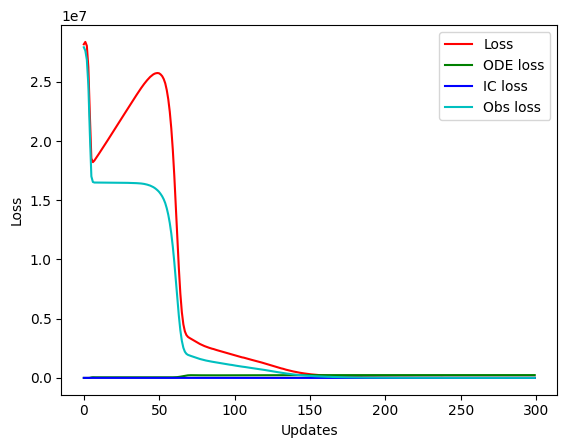

In [15]:
# train network

#getting epoch sizes
num_samples_train = t_tensor.shape[0]
num_batches_train = num_samples_train // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
cur_loss = 0
losses, ode_losses, ic_losses, obs_losses = [], [], [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    ode_loss = 0
    ic_loss = 0
    obs_loss = 0
    net.train()
    for i in range(num_batches_train):
        # Zero the gradients for all optimizers
        optimizer_weights.zero_grad()
        optimizer_ode.zero_grad()
        optimizer_ic.zero_grad()

        slce = get_slice(i, batch_size)
        output = net(t_tensor[slce])

        # compute gradients given loss
        batch_loss_ode = loss_ode(net, t_tensor)
        batch_loss_ic = loss_ic(net)
        batch_loss_obs = loss_obs(net, t_tensor, SIR_obs)
        #batch_loss = lambda_ode * batch_loss_ode + lambda_ic * batch_loss_ic + lambda_obs * batch_loss_obs # with soft adaptation
        batch_loss = lambda_obs * batch_loss_obs + lambda_ic * batch_loss_ic
        batch_loss.backward()

        #maximize gradients of lambdas by inverting the gradient
        with torch.no_grad():
            #lambda_ode.grad *= -1
            lambda_ic.grad *= -1
            lambda_obs.grad *= -1

        #update net and lambdas
        optimizer_weights.step()
        #optimizer_ode.step()
        optimizer_ic.step()
        optimizer_obs.step()

        cur_loss += batch_loss.detach().numpy()
        ode_loss += batch_loss_ode.detach().numpy()
        ic_loss += batch_loss_ic.detach().numpy()
        obs_loss += batch_loss_obs.detach().numpy()

    losses.append(cur_loss / batch_size)
    ode_losses.append(ode_loss / batch_size)
    ic_losses.append(ic_loss / batch_size)
    obs_losses.append(obs_loss / batch_size)

    net.eval()

    if epoch % 50 == 0:
        print(
            f"epoch {epoch+1} : Total loss {np.round(losses[-1].item(), decimals=3)} , "
            f"ode loss: {np.round(ode_losses[-1].item(), decimals=3)} , "
            f"ode lambda: {np.round(lambda_ode.item(), decimals=3)} , "
            f"ic loss: {np.round(ic_losses[-1].item(), decimals=3)} , "
            f"ic lambda: {np.round(lambda_ic.item(), decimals=3)} , "
            f"obs loss: {np.round(obs_losses[-1].item(), decimals=3)} , "
            f"obs lambda: {np.round(lambda_obs.item(), decimals=3)}"
    )


epoch = np.arange(len(losses))
plt.figure()
plt.plot(epoch, losses, 'r')
plt.plot(epoch, ode_losses, 'g')
plt.plot(epoch, ic_losses, 'b')
plt.plot(epoch, obs_losses, 'c')
plt.legend(['Loss', 'ODE loss', 'IC loss', "Obs loss"])
plt.xlabel('Updates'), plt.ylabel('Loss')

## Visualization

In [16]:
def SIR_net_numpy(t):
    SIR = net(t)
    S_net = SIR[:, 0].detach().numpy()
    I_net = SIR[:, 1].detach().numpy()
    R_net = SIR[:, 2].detach().numpy()
    return S_net, I_net, R_net

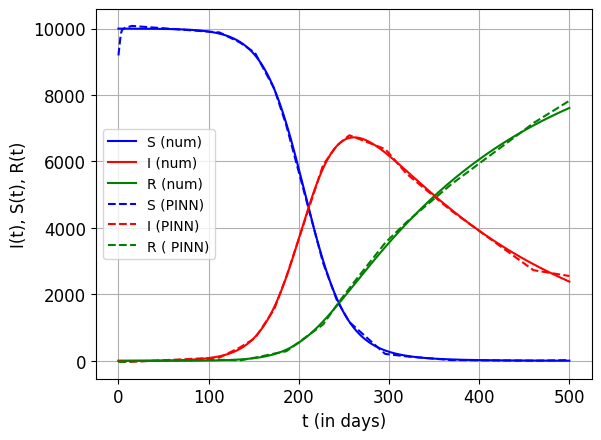

In [17]:
#numerical solution
S_num, I_num, R_num = SIR_numerical(t_array)
#PINN solution
S_net, I_net, R_net = SIR_net_numpy(t_tensor)

plt.figure()
plt.plot(t_array, S_num, color="blue")
plt.plot(t_array, I_num, color="red")
plt.plot(t_array, R_num, color="green")
plt.plot(t_array, S_net, color="blue", linestyle="--")
plt.plot(t_array, I_net, color="red", linestyle="--")
plt.plot(t_array, R_net, color="green", linestyle="--")
plt.xlabel('t (in days)', fontsize = 12)
plt.ylabel('I(t), S(t), R(t)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.legend(["S (num)", "I (num)", "R (num)", "S (PINN)", "I (PINN)", "R ( PINN)"])
plt.show()